<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/07_ensemble_learning_voting_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensamble Learning: Voting Classifiers

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply voting classifier to improve learning score

## Load Dataset

In [8]:
from sklearn.datasets import make_moons

from sklearn.ensemble import VotingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [4]:
# Create dataset
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

# Split dataset to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Default test size 25% of X

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (375, 2)
y_train shape: (375,)

X_test shape: (125, 2)
y_test shape: (125,)


In [44]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('svc', SVC(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))])

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [12]:
voting_clf.named_estimators_ # Returns a {dict} to access fitted sub-estimators by name

{'lr': LogisticRegression(random_state=42),
 'svc': SVC(random_state=42),
 'rf': RandomForestClassifier(random_state=42)}

In [15]:
# Get sub-classifier's scores on test set
print("Sub-classifier's scores on test set:")
for name, clf in voting_clf.named_estimators_.items():
    print(f"{name}: score={clf.score(X_test, y_test)}")

Sub-classifier's scores on test set:
lr: score=0.864
svc: score=0.896
rf: score=0.896


In [16]:
# Get voting classifier score on test set
print(f"Voting classifier's score on test set: {voting_clf.score(X_test, y_test)}")

Voting classifier's score on test set: 0.912


The voting classifier score (0.912) is higher than each individual classifiers. Let's also compare the prediction of the voting classifier to its sub-classifiers on one of the test examples, say the fisrt one at index 0).

In [26]:
X_test[:1]

array([[0.50169252, 0.21717211]])

In [24]:
X_test[:1]

array([[0.50169252, 0.21717211]])

In [28]:
print(f"Voting classifier's prediction: {voting_clf.predict(X_test[:1])}\n")

for name, clf in voting_clf.named_estimators_.items():
    print(f"{name}'s prediction: {clf.predict(X_test[:1])}")

Voting classifier's prediction: [1]

lr's prediction: [1]
svc's prediction: [0]
rf's prediction: [1]


The first example is classified as class-1 by the voting classifier because 2 out of 3 sub-classifiers classified the first example as class-1 (hard-voting or majority voting classifier).

## Soft Voting

In __soft voting__, the classifier compute the average probability of all the sub-classifiers, then predict the class with thhe highest class probability.<br>

I need to slightly change the input argument to do so. There are two options to do it:
* Modify the argument of the existing classifier
* Create a new classifier with new arguments

In [76]:
# Assume I have define voting classifier as follows
voting_clf1 = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('svc', SVC(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))])

In [77]:
# Method 1: Modify the argument of the existing classifier
voting_clf1.voting = "soft"

# "probability" argument need to be set to "True" so voting classifier can perform soft voting
voting_clf1.named_estimators['svc'].probability = True

voting_clf1.fit(X_train, y_train)
print(f"Voting classifier's score on test set: {voting_clf1.score(X_test, y_test)}")


Voting classifier's score on test set: 0.92


There is slight improvement in classification score (0.92 as opposed to 0.912). Method 2 is implemented as follows.

In [34]:
# Method 2: Create a new classifier with new arguments
voting_clf_soft = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('svc', SVC(random_state=42, probability=True)),
        ('rf', RandomForestClassifier(random_state=42))],
    voting='soft')

voting_clf_soft.fit(X_train, y_train)
print(f"Voting classifier's score on test set: {voting_clf_soft.score(X_test, y_test)}")

Voting classifier's score on test set: 0.92


## Cloning Sub-Classifiers
__VotingClassifier__ clones each etimators and fits the clones. So trying to reach the parameters of the original estimator will returns the un-fitted version. Let's me demonstrate what I mean.

In [68]:
X_new = [[0,2], [1,0]]

# Access the original 'lr' classifier using .named_estimator and use it to predict on two new instances
voting_clf.named_estimators['lr'].predict(X_new) # Returns NotFittedError

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [69]:
# Access the cloned 'lr' classifier (fitted) using .named_estimator_
voting_clf.named_estimators_['lr'].predict([[0,2], [1,0]]) # Returns the classes

array([0, 1])

Here is some highlights:
* `.named_estimator` provides access to the original unfitted estimators
* `.named_estimator_` provides access to the fitted estimators
Note that if I am interested to get the probabilities instead of the predictions I should use `predict_proba`.

In [65]:
voting_clf.named_estimators_['lr'].predict_proba([[0,2], [1,0]])

array([[0.99840759, 0.00159241],
       [0.21252461, 0.78747539]])

For the first instance, since the probability at index 0 is higher, it is predicted of class-0. However, for the second instance, it is of class-1 because the predicted probability at index 1 is higher (0.787 > 0.212).

## Plot Datasets

In [101]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#F9F7F7', '#3F72AF'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # field
    ax.contour(x1, x2, y_pred, cmap="crest", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels, s=50, alpha=0.7):
    for i in range(len(styles)):
        sns.scatterplot(x=X[:, 0][y == i], y=X[:, 1][y == i], ax=ax, marker=styles[i][0], color=styles[i][1], s=s, edgecolor='k', alpha=alpha)

    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

First, I want to see how each estimator performed. So, I plot the the classification boundary for each of them.

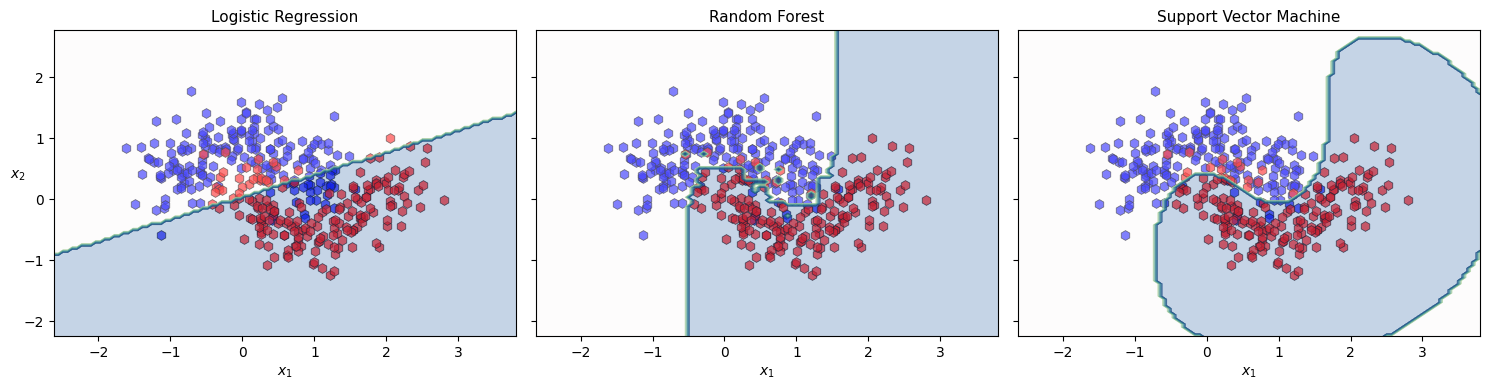

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

plot_points(X_train, y_train, axes[0], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(voting_clf.named_estimators_['lr'], X_train, y_train, axes[0])
axes[0].set_title("Logistic Regression", fontsize=11)

plot_points(X_train, y_train, axes[1], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(voting_clf.named_estimators_['rf'], X_train, y_train, axes[1])
axes[1].set_title("Random Forest", fontsize=11)

plot_points(X_train, y_train, axes[2], [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(voting_clf.named_estimators_['svc'], X_train, y_train, axes[2])
axes[2].set_title("Support Vector Machine", fontsize=11)

plt.tight_layout()
plt.show()

The Logistic Regression classification is obviousely an underfit. SVC performed better without fine-tunning any of its hyperparameters. However, Random forest seems to the winner. Now let's take a look at the two voting classifiers, _hard_ and _soft_.

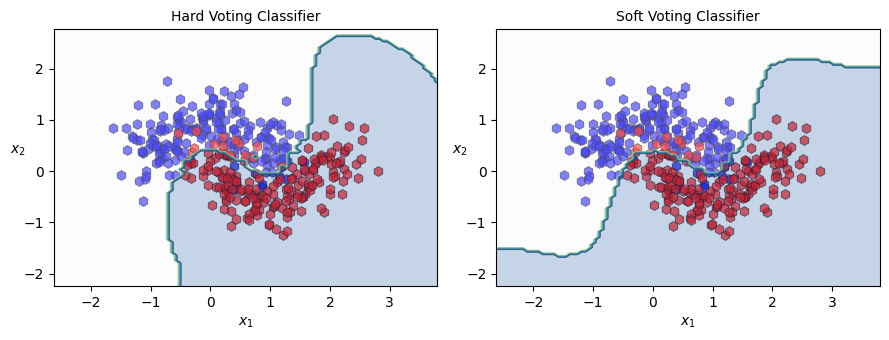

In [111]:
plt.figure(figsize=(9, 3.5))

axis1 = plt.subplot(121)
plot_points(X_train, y_train,axis1, [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(voting_clf, X_train, y_train, axis1)
axis1.set_title("Hard Voting Classifier", fontsize=10)

axis2 = plt.subplot(122, sharey=axis1)
plot_points(X_train, y_train, axis2, [("h", "blue"), ("h", "red")], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(voting_clf_soft, X_train, y_train, axis2)
axis2.set_title("Soft Voting Classifier", fontsize=10)

plt.tight_layout()
plt.show()

The two boundaries look slightly different. We know the scores are too close (0.912 for the hard and 0.92 for the soft).